<a href="https://colab.research.google.com/github/soraennon/UNet_SemanticSegmentation/blob/main/UNet_SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import glob
import cv2
import natsort
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import copy
from tqdm.auto import tqdm
import time

In [ ]:
# For augmentation library
!pip install -U git+https://github.com/albu/albumentations > /dev/null

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7w_kj9u9


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe.")

print("device name", torch.cuda.get_device_name(0))



import gc
gc.collect()
torch.cuda.empty_cache()

device name Tesla T4


# Labeling

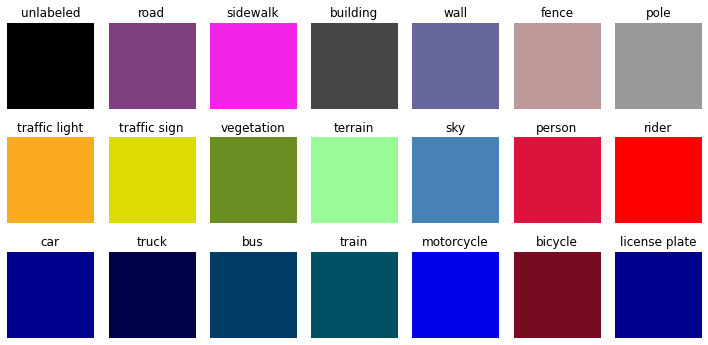

In [ ]:
void_id = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30]
id = [255, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, -1]
names = ['unlabeled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 
         'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 
         'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'license plate']
colors = [[0,0,0],[128,64,128],[244,35,232],[70,70,70],[102,102,156],[190,153,153],[153,153,153],
          [250,170,30],[220,220,0],[107,142,35],[152,251,152],[70,130,180],[220,20,60],[255,0,0],
          [0,0,142],[0,0,70],[0,60,100],[0,80,100],[0,0,230],[119,11,32],[0,0,142]]

class_map = dict(zip(id, range(len(id))))
n_classes = len(id)
label_colors = dict(zip(range(n_classes), colors))



def encode(mask, id=id, void_id=void_id, class_map=class_map):
  for vid in void_id:
    mask[mask == vid] = 255.
  for i in id:
    mask[mask == i] = class_map[i]
  return mask


# convert grayscale to color
def decode(temp, n_classes=n_classes, label_colors=label_colors):  
  temp = temp.numpy()
  r = temp.copy()
  g = temp.copy()
  b = temp.copy()
  for l in range(0, n_classes):
      r[temp == l] = label_colors[l][0]
      g[temp == l] = label_colors[l][1]
      b[temp == l] = label_colors[l][2]

  rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
  rgb[:, :, 0] = r / 255.0
  rgb[:, :, 1] = g / 255.0
  rgb[:, :, 2] = b / 255.0
  return rgb


fig = plt.figure(figsize=(10, 5))
for i in range(len(label_colors)):
    fig.add_subplot(3, 7, i+1)
    plt.title(names[i])
    plt.imshow(np.broadcast_to(label_colors[i], (12 ,12 ,3))/255.)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Load Dataset

In [ ]:
def KittiTrainValDataset(img_dir, mask_dir, val_frac=.2):
  # Split files from the dataset into the train and validation sets
  train_dataset, val_dataset = [], []

  fnames = os.listdir(img_dir)
  np.random.shuffle(fnames)

  train_len = int((1 - val_frac) * len(fnames))

  for i, fname in enumerate(fnames):  
    img_path = os.path.join(img_dir, fname)
    mask_path = os.path.join(mask_dir, fname)

    pair = (img_path, mask_path)

    if i < train_len:
      train_dataset.append(pair)
    else:
      val_dataset.append(pair)

  return train_dataset, val_dataset


def KittiTestDataset(img_dir):
  names = os.listdir(img_dir)
  dataset = [os.path.join(img_dir, name) for name in names]
  return dataset

In [ ]:
def mask_plot(img, mask):
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)


  # class labels after label correction
  seg = torch.Tensor(mask)
  res1 = encode(seg)

  # coloring
  res2 = decode(res1)
  
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  plt.imshow(mask,cmap='gray')  
  plt.axis('off')
  plt.show()

  plt.imshow(res1,cmap='gray')  
  plt.axis('off')
  plt.show()

  plt.imshow(res2)
  plt.axis('off')
  plt.show()

# Augmentation (preprocessing)

In [ ]:
# Augmentation

class AugmentedDataset(Dataset):
  def __init__(self, dataset, crop=None, transform=None):
    self.dataset = dataset
    self.crop = crop
    self.transform = transform
      
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):    
    image = self.dataset[idx][0]
    mask = self.dataset[idx][1]

    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    if self.transform:
      augmented = self.transform(image=image) 
      image = augmented['image']

    if self.crop:
      cropping = self.crop(image=image, mask=mask) 
      image = cropping['image']
      mask = cropping['mask']

    return image, mask

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    
    for i in range(samples):
        image, mask = dataset[idx]

        ax[i, 0].imshow(image.permute(1,2,0))
        mask = encode(mask)
        mask = decode(mask)
        ax[i, 1].imshow(mask, cmap='gray', interpolation="nearest")        
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


# visualize_augmentations(train_dataset, idx=50)

# UNet

In [ ]:
# UNet

# 반복되는 conv - BN - ReLU 구조 모듈화
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.double_conv(x)

# Downscaling with maxpool then double conv
class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.down_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.down_conv(x)

# Upscaling then double conv
class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)

    # padding
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX //2, diffY // 2, diffY - diffY //2])
      
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    
    self.in_conv = DoubleConv(in_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    self.down4 = Down(512, 1024 // 2)
    self.up1 = Up(1024, 512 // 2)
    self.up2 = Up(512, 256 // 2)
    self.up3 = Up(256, 128 // 2)
    self.up4 = Up(128, 64)
    self.out_conv = OutConv(64, out_channels)    

  def forward(self, x):
    # print(x.shape)
    # x = x.permute(0,1,3,2) # [N, C, H, W] -> [N, C, W, H]
    # print(x.shape)
    x1 = self.in_conv(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    x = self.out_conv(x)
    return x #torch.sigmoid(x)

In [ ]:
def train_epoch(model, train_loader):
  model.train()
  train_loss, train_IoU, count = 0, 0, 0

  for X, Y in tqdm(train_loader, total=len(train_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    Y = encode(Y) 

    # Forward
    Y_pred = model(X)

    loss = criterion(Y_pred, Y.long())
    train_loss += loss.item()    
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count += Y.shape[0]
  
  return train_loss/count



def val_epoch(model, val_loader):
  model.eval()
  val_loss, val_IoU, count = 0, 0, 0

  for batch, (X, Y) in enumerate(val_loader):    
    # mask_type = torch.float32 if model.out_channels == 1 else torch.long  
    # X, Y = X.to(device, dtype=torch.float32), Y.to(device, dtype=mask_type) / 255.
    X, Y = X.to(device), Y.to(device)
    Y = encode(Y) 
    Y_pred = model(X)
    loss = criterion(Y_pred, Y.long()) # Gray
    # IoU = calculate_iou_batch(Y_pred, Y)

    val_loss += loss.item()
    # val_IoU += IoU    
    count += Y.shape[0]
    
  return val_loss/count #, val_IoU/count


# Train

In [ ]:
def train(model, epochs, train_loader, val_loader, model_path):
  train_losses, val_losses = [], []
  best = 1e9

  for epoch in tqdm(range(1, epochs+1)):
    train_loss = train_epoch(model, train_loader)
    val_loss = val_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("[Epoch {:3d}]  train_loss: {:.4f} \t val_loss: {:.4f}".format(epoch, train_loss, val_loss))


    if (model_load == False) and (val_loss < best):
      best = val_loss
      torch.save(model.state_dict(), model_path)
      print('best model saved')

  return train_losses, val_losses

In [ ]:
def plot_loss(train_losses, val_losses):
  plt.figure(figsize=(25,5))
  plt.plot(train_losses,'-o')
  plt.plot(val_losses,'-o')
  plt.xlabel('epochs')
  plt.ylabel('losses')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.legend(['Train Loss','Val Loss'])
  plt.title('Train Loss and Val Loss')
  plt.show()

# Inference

In [ ]:
def test(loader):
  X, Y = next(iter(loader))
  X, Y = X.to(device), Y.to(device)
  Y_pred = model(X)


  plt.figure(figsize=(10,15))
  for i, (image, mask, pred_mask) in enumerate(zip(X, Y, Y_pred)):
    # __________image_________________
    plt.subplot(X.shape[0], 3, i*3+1)  
    plt.axis('off')  
    plt.title('image')
    temp = image.clone().cpu().permute(1,2,0)
    temp = np.array(temp) 
    temp = ((temp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
    temp = np.clip(temp,0,255)
    plt.imshow(temp)

    # __________mask_________________
    plt.subplot(X.shape[0], 3, i*3+2)  
    plt.axis('off')  
    plt.title('Actual')
    temp = mask.clone().cpu() 
    temp = encode(temp)
    temp = decode(temp)
    plt.imshow(temp)

    # __________predicted mask_________________
    plt.subplot(X.shape[0], 3, i*3+3)  
    plt.axis('off')  
    plt.title('Predict')
    temp = pred_mask.clone().squeeze(0).detach().cpu()
    temp = decode(torch.argmax(temp, 0))
    plt.imshow(temp)
  plt.tight_layout()
  plt.show()

# Main

In [ ]:
# load dataset
KITTI = "/content/drive/MyDrive/Test/kitti_data_semantics"

train_path = os.path.join(KITTI, 'training')
train_img_dir = os.path.join(train_path, 'image_2')
train_seg_dir = os.path.join(train_path, 'semantic_rgb')
train_mask_dir = os.path.join(train_path, 'semantic')
test_img_dir = os.path.join(KITTI, 'testing/image_2')


# Split train, val set
train_dataset_, val_dataset_ = KittiTrainValDataset(train_img_dir, train_mask_dir)
test_dataset_ = KittiTestDataset(test_img_dir)

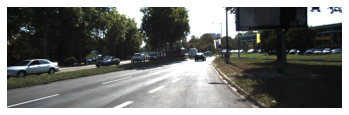

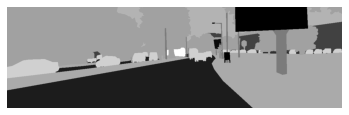

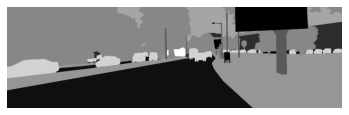

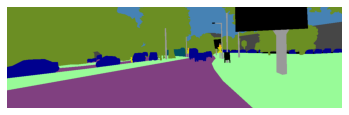

In [ ]:
i = 16
mask_plot(train_dataset_[i][0], train_dataset_[i][1])

In [ ]:
# Augmentatation

batch_size = 4

crop_transform = A.Compose([A.RandomCrop(256, 256), 
                            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(transpose_mask=True)])

crop_transform2 = A.Compose([A.RandomCrop(256, 256), 
                            ToTensorV2(transpose_mask=True)])

train_transform = A.Compose([
  A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ])

val_transform = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])


train_dataset = AugmentedDataset(train_dataset_, transform=train_transform, crop=crop_transform)
val_dataset = AugmentedDataset(val_dataset_, transform=val_transform, crop=crop_transform2)
# test_dataset = AugmentedDataset(test_dataset_, crop=crop_transform2)


# DataLoader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

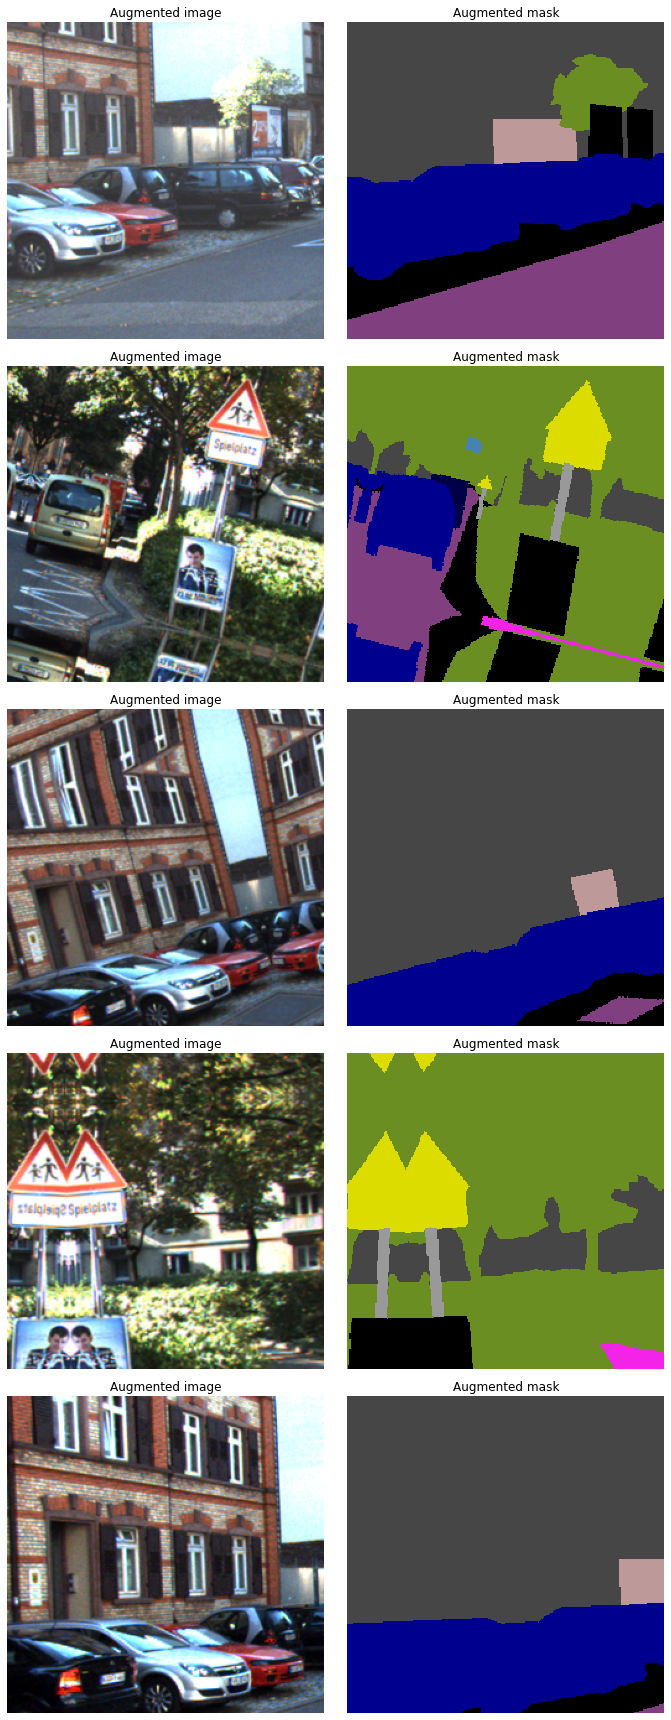

In [ ]:
visualize_augmentations(train_dataset, idx=50)

In [ ]:
# # Setting parameters
lr = 1e-3
epochs = 50

mode = 'train'
# mode = 'test'

model_load = False
model_dir = "/content/drive/MyDrive/Test/2_UNet_checkpoint/"
model_name = "UNet.pth"
model_path = model_dir + model_name

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(3,n_classes).to(device)

if model_load:
  model.load_state_dict(torch.load(model_path))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)

In [ ]:
from torchsummary import summary

# input_size=(channels, H, W)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   1]  train_loss: 0.5584 	 val_loss: 0.4572
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   2]  train_loss: 0.4355 	 val_loss: 0.7278


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   3]  train_loss: 0.3913 	 val_loss: 0.3374
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   4]  train_loss: 0.3512 	 val_loss: 0.3430


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   5]  train_loss: 0.3603 	 val_loss: 0.3123
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   6]  train_loss: 0.3312 	 val_loss: 0.3464


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   7]  train_loss: 0.3312 	 val_loss: 0.2931
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   8]  train_loss: 0.3352 	 val_loss: 0.3528


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch   9]  train_loss: 0.3148 	 val_loss: 0.2970


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  10]  train_loss: 0.3292 	 val_loss: 0.3436


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  11]  train_loss: 0.3403 	 val_loss: 0.2939


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  12]  train_loss: 0.3279 	 val_loss: 0.2868
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  13]  train_loss: 0.2994 	 val_loss: 0.2650
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  14]  train_loss: 0.3005 	 val_loss: 0.3403


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  15]  train_loss: 0.2972 	 val_loss: 0.3131


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  16]  train_loss: 0.3229 	 val_loss: 0.2503
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  17]  train_loss: 0.2913 	 val_loss: 0.2457
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  18]  train_loss: 0.3004 	 val_loss: 0.3198


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  19]  train_loss: 0.2968 	 val_loss: 0.2376
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  20]  train_loss: 0.2969 	 val_loss: 0.2675


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  21]  train_loss: 0.2929 	 val_loss: 0.2348
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  22]  train_loss: 0.2980 	 val_loss: 0.2543


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  23]  train_loss: 0.2743 	 val_loss: 0.2284
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  24]  train_loss: 0.2770 	 val_loss: 0.2537


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  25]  train_loss: 0.2659 	 val_loss: 0.2482


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  26]  train_loss: 0.2846 	 val_loss: 0.2163
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  27]  train_loss: 0.2684 	 val_loss: 0.2834


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  28]  train_loss: 0.2933 	 val_loss: 0.2515


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  29]  train_loss: 0.2789 	 val_loss: 0.3073


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  30]  train_loss: 0.2679 	 val_loss: 0.2832


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  31]  train_loss: 0.2775 	 val_loss: 0.2476


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  32]  train_loss: 0.2676 	 val_loss: 0.2351


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  33]  train_loss: 0.2883 	 val_loss: 0.2309


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  34]  train_loss: 0.2795 	 val_loss: 0.2722


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  35]  train_loss: 0.2955 	 val_loss: 0.2827


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  36]  train_loss: 0.2778 	 val_loss: 0.2390


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  37]  train_loss: 0.2831 	 val_loss: 0.2195


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  38]  train_loss: 0.2654 	 val_loss: 0.2204


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  39]  train_loss: 0.2705 	 val_loss: 0.2612


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  40]  train_loss: 0.2554 	 val_loss: 0.2014
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  41]  train_loss: 0.2754 	 val_loss: 0.2022


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  42]  train_loss: 0.2656 	 val_loss: 0.2444


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  43]  train_loss: 0.2575 	 val_loss: 0.2304


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  44]  train_loss: 0.2581 	 val_loss: 0.2721


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  45]  train_loss: 0.2492 	 val_loss: 0.2630


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  46]  train_loss: 0.2541 	 val_loss: 0.1946
best model saved


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  47]  train_loss: 0.2293 	 val_loss: 0.2234


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  48]  train_loss: 0.2504 	 val_loss: 0.2712


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  49]  train_loss: 0.2554 	 val_loss: 0.2275


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch  50]  train_loss: 0.2557 	 val_loss: 0.2485


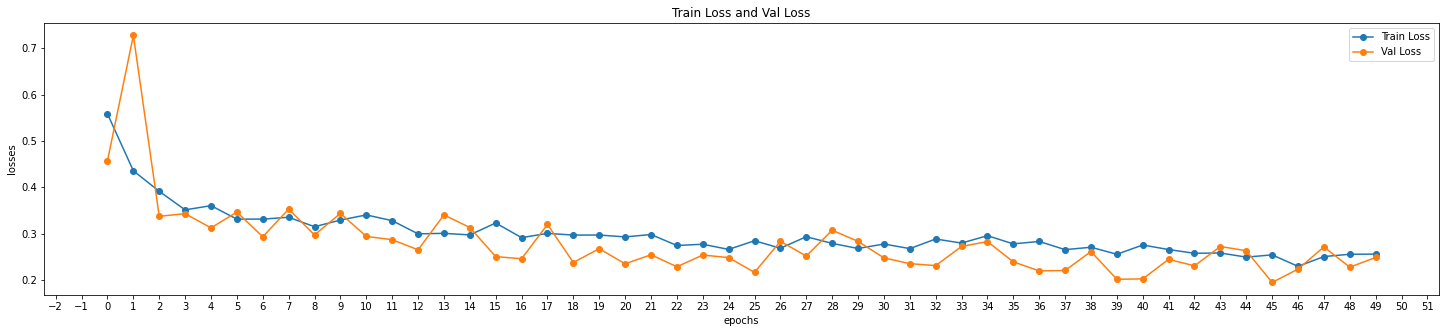

In [ ]:
if mode == 'train':
  train_loss, val_loss = train(model, epochs, train_loader, val_loader, model_path)
  plot_loss(train_loss, val_loss)

elif mode == 'test':
  test(val_loader)

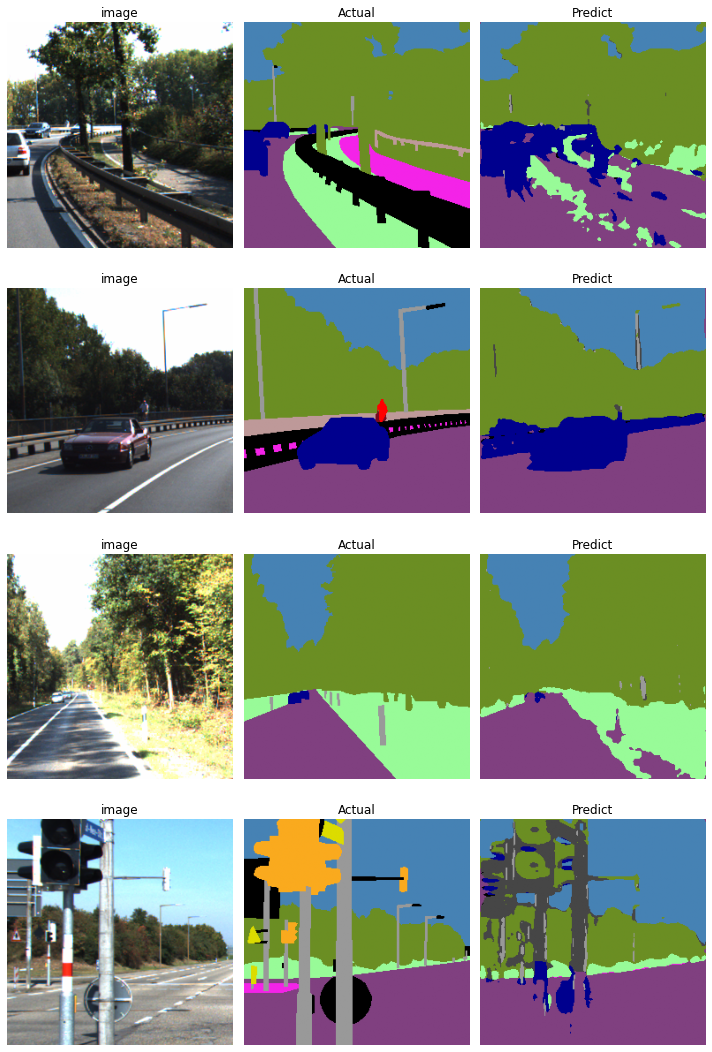

In [ ]:
# mode = 'test'
test(val_loader)